## Introduction {.unnumbered}

This final chapter of the [CrimeGraph](https://www.subelsky.com/crimegraph/) project will search for the optimal way to train the [GLDNet model](https://www.subelsky.com/crimegraph/model_development/) to predict the locations of violent crime events in Baltimore City, using features engineered from [SpotCrime event reports](https://www.subelsky.com/crimegraph/event_timestep_feature_engineering/), mapped onto nodes in a [graph of Baltimore City street segments](https://www.subelsky.com/crimegraph/street_graph_feature_engineering/).

The source code for this project is available on [GitHub](https://github.com/subelsky/crimegraph).

## Load Nodes and Features

We start by loading the street graph and features prepared in the first three parts of the project:

In [38]:
#| code-fold: true

import pickle
import pandas as pd
from lib.data import load_timesteps, create_data_tensor

file_path = '../../data/processed/baltimore_street_graph.gpickle'

with open(file_path, 'rb') as f:
    G = pickle.load(f)

num_nodes = G.number_of_nodes()
print(f'Loaded street graph with {num_nodes} nodes and {len(G.edges)} edges')

file_path = '../../data/processed/timesteps.csv.gz'
timesteps = load_timesteps(file_path)

print(f'Loaded {len(timesteps)} timesteps')

data_tensor = create_data_tensor(timesteps, num_nodes)

print(f'Loaded data tensor: {data_tensor.shape}')

Loaded street graph with 1177 nodes and 3469 edges
Loaded 278134 timesteps


## Prepare Training, Validation, and Test Data

Here we split the crime events into separate datasets for training (70%), validating (15%), and testing (15%). The slices are taken in chronological order, so we can determine if using historic data (the first 70%) to train a model can make accurate predictions of more recent events (contained in the remaining 30%).

Validation data is used to evaluate the model's performance after every training cycle.  The training process can halt early if validation performance starts to decline, saving time and resources. Checking progress with validation data also helps avoid overfitting, where the model simply memorizes the training data without being able generalize to new, previously-unseen data.

Test data is used to evaluate the model's final quality after all training cycles complete.

In [ ]:
#| code-fold: true
import importlib; import lib.data; importlib.reload(lib.data)
from lib.data import create_training_datasets

training_data, validation_data, test_data = create_training_datasets(
    data_tensor,
    training_fraction=0.7,
    validation_fraction=0.15,
    lookback_timesteps=14
)

print(f'Created training data with {len(training_data)} timesteps')
print(f'Created validation data with {len(validation_data)} timesteps')
print(f'Created test data with {len(test_data)} timesteps')

# Smaller batch sizes can lead to noisier gradient updates, helping the model escape local minima,
# potentially leading to better generalization.
batch_size = 30

training_data = training_data.batch(batch_size)
validation_data = validation_data.batch(batch_size)
test_data = test_data.batch(batch_size)

Creating total_windows: 3232 with 14 lookback timesteps
Created training data with 2248 timesteps
Created validation data with 470 timesteps
Created test data with 472 timesteps


## Set Default Hyperparameter Values

Hyperparameters adjust the learning behavior of the model and control the training process itself. Here we lay out starting values, based on those used in the GLDNet paper.

In [1]:
# Controls the size and complexity of the GatedRelu component, which learns spatial features
default_num_gated_relu_layers = 2
default_num_gated_relu_hidden_units = 8

# Controls the size and complexity of the LocalizedDiffusionNetwork component, which learns temporal features
default_num_ldn_layers = 5
default_num_ldn_hidden_units = 4

# Defines how the model learns from prediction errors
default_loss_rho = 0.03
rho_tuning_step = 0.005

## Build Tunable Model

The next function builds the GLDNet model using the code written in part 3, wrapping all of its tunable parameters with `keras_tuner.HyperParameters` from the [keras tuner library](https://keras.io/api/keras_tuner/).

`keras_tuner` will build new versions of our model while conducting an automatic search for the most optimal combination of hyperparameters. We will use Hit Rate Accuracy to evaluate the effectiveness of each combination. See [part 3](/crimegraph/model_development/#create-metrics) for details.

In [ ]:
from lib.model import build_model
from lib.metrics import HitRateMetric
import keras_tuner

metrics = [HitRateMetric(num_nodes, coverage=0.2)]

def build_tunable_model(hp, **kwargs):
    """Sets up the GLDNet model with hyperparameters that can be tuned by the Keras Tuner"""
    num_gated_relu_layers = hp.Int("num_gated_relu_layers", min_value=1, max_value=4, step=1, default=default_num_gated_relu_layers)
    num_gated_relu_hidden_units = hp.Choice("num_gated_relu_hidden_units", [2,4,8,16], default=default_num_gated_relu_hidden_units, ordered=False)

    num_ldn_layers = hp.Int("num_ldn_layers", min_value=1, max_value=7, step=1, default=default_num_ldn_layers)
    num_ldn_hidden_units = hp.Choice("num_ldn_hidden_units", [2,4,8,16], default=default_num_ldn_hidden_units, ordered=False)

    loss_rho = hp.Float("loss_rho", min_value=0.005, max_value=0.035, step=rho_tuning_step, default=default_loss_rho)

    hyperparameters = {
        'num_gated_relu_layers': num_gated_relu_layers,
        'num_gated_relu_hidden_units': num_gated_relu_hidden_units,
        'num_ldn_layers': num_ldn_layers,
        'num_ldn_hidden_units': num_ldn_hidden_units,
        'loss_rho': loss_rho
    }

    model = build_model(G, metrics, **hyperparameters)

    return model

## Setup Local Hyperparameter Search

Instead of making random guesses, we will use the [Hyperband](https://arxiv.org/abs/1603.06560) algorithm, which speeds up the search through "..adaptive resource allocation and early-stopping." It tries many different variable combinations, quickly discarding those that are not promising.

`val_hit_rate` is the Hit Rate Accuracy metric applied to the validation set during training. Low `val_hit_rate` values can trigger early stopping.

In [ ]:
objective = keras_tuner.Objective("val_hit_rate", direction="max")

tuner = keras_tuner.Hyperband(
    hypermodel=build_tunable_model,
    objective=objective,
    hyperband_iterations=5, # number of times to run the entire hyperband process
    factor=2,               # reduction factor for the number of configurations & epochs in successive rounds
    overwrite=False,
    directory="./tuning/",
    project_name="crimegraph",
    max_epochs=25           # maximum number of epochs to train each model in any trial
)

## Review Search Space

`keras_tuner` reports the five hyperparameters along with the ranges of values to be searched by the Hyperband algorithm:

In [ ]:
#| code-fold: true
tuner.search_space_summary()

Search space summary
Default search space size: 5
num_gated_relu_layers (Int)
{'default': 2, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
num_gated_relu_hidden_units (Choice)
{'default': 8, 'conditions': [], 'values': [2, 4, 8, 16], 'ordered': False}
num_ldn_layers (Int)
{'default': 5, 'conditions': [], 'min_value': 1, 'max_value': 7, 'step': 1, 'sampling': 'linear'}
num_ldn_hidden_units (Choice)
{'default': 4, 'conditions': [], 'values': [2, 4, 8, 16], 'ordered': False}
loss_rho (Float)
{'default': 0.03, 'conditions': [], 'min_value': 0.005, 'max_value': 0.035, 'step': 0.005, 'sampling': 'linear'}


## Conduct First Local Hyperparameter Search

In [ ]:
tuner.search(
    training_data,
    validation_data=validation_data
)

Trial 460 Complete [00h 30m 15s]
val_hit_rate: 0.3402770459651947

Best val_hit_rate So Far: 0.42056429386138916
Total elapsed time: 2d 07h 58m 40s


460 trials were conducted over 2 days, with 42% validation hit rate accuracy. The 3 best combinations of hyperparameters were:

In [ ]:
#| code-fold: true
tuner.results_summary(num_trials=3)

Results summary
Results in ./tuning/crimegraph
Showing 3 best trials
Objective(name="val_hit_rate", direction="max")

Trial 0167 summary
Hyperparameters:
num_gated_relu_layers: 2
num_gated_relu_hidden_units: 2
num_ldn_layers: 2
num_ldn_hidden_units: 16
loss_rho: 0.034999999999999996
tuner/epochs: 25
tuner/initial_epoch: 13
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0164
Score: 0.42056429386138916

Trial 0312 summary
Hyperparameters:
num_gated_relu_layers: 1
num_gated_relu_hidden_units: 16
num_ldn_layers: 2
num_ldn_hidden_units: 16
loss_rho: 0.030000000000000002
tuner/epochs: 13
tuner/initial_epoch: 7
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 0307
Score: 0.41897380352020264

Trial 0164 summary
Hyperparameters:
num_gated_relu_layers: 2
num_gated_relu_hidden_units: 2
num_ldn_layers: 2
num_ldn_hidden_units: 16
loss_rho: 0.034999999999999996
tuner/epochs: 13
tuner/initial_epoch: 7
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0160
Score: 0.418028324842453


## Train and Test Model with Best Hyperparameters

The model can now be trained from scratch using the best set of hyperparameters and presented with test data to demonstrate hit rate prediction acccuracy for events that it has never seen before.

In [ ]:
hyperparameters = {
    'num_gated_relu_layers': 2,
    'num_gated_relu_hidden_units': 2,
    'num_ldn_layers': 2,
    'num_ldn_hidden_units': 16,
    'loss_rho': 0.034999999999999996
}

model = build_model(G, metrics, **hyperparameters)

In [ ]:
training_history = model.fit(training_data, epochs=25, validation_data=validation_data, verbose=0)

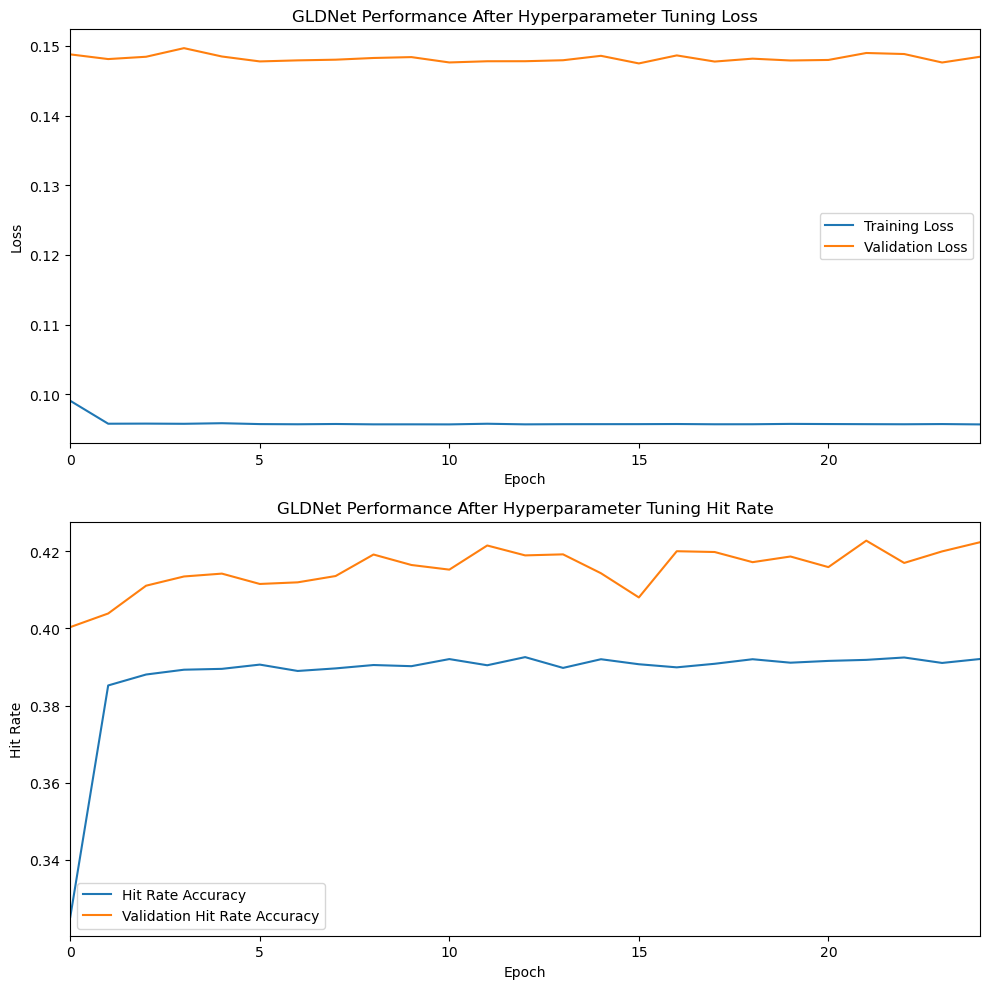

In [ ]:
#| code-fold: true
from lib.plots import plot_loss_and_metrics

plot_loss_and_metrics(training_history.history, name='GLDNet Performance After Hyperparameter Tuning')

In [ ]:
test_result = test_model(model, test_data, batch_size, metrics)
test_result

{'hit_rate': 0.40578887}

40.5% hit rate accuracy on the test data is well below the 60% value reported by the GLDnet paper, and the flat loss function indicates that not much learning is occuring. To improve accuracy, I began a long series of experiments to adjust the model architecture while searching for new hyperparameter combinations. Most of the experimental results looked like this:

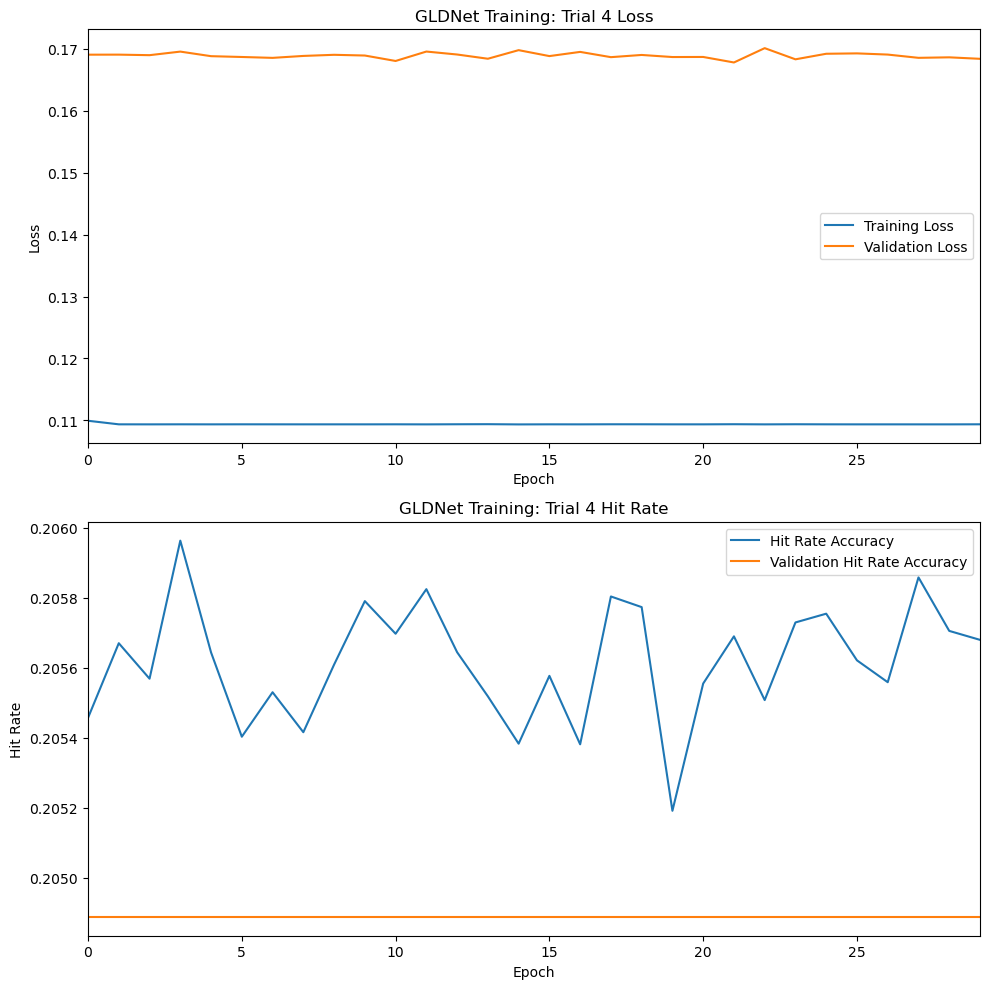

Loss rates were usually flat, while validation accuracy fluctuated, suggesting that the model was not generalizing well. The most significant model change I tried was adding [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) and [Regularization](https://keras.io/2.15/api/layers/regularizers/) layers, but this seemed to overcomplicate the architecture and resulted in even worse, more unstable performance.

## Augmenting With a Sliding Window

I re-examined the training process and realized that the model was being trained on a relatively small amount of data. Each batch presented to the model contained a series of continuous timesteps, with no overlap between batches. The model would use training events from days 1-10 to make a prediction for day 11, and use events from days 11-20 to make a prediction for day 21^[The batches are shuffled during each training run, so they are not presented to the model in chronological order].

I modified the data loading code to return a 'sliding window' of events overlapping between batches. The model could now use events from days 1-10 to predict day 11 and use events from days 2-11 to make a prediction for day 12, resulting in many more batches and a much richer dataset.

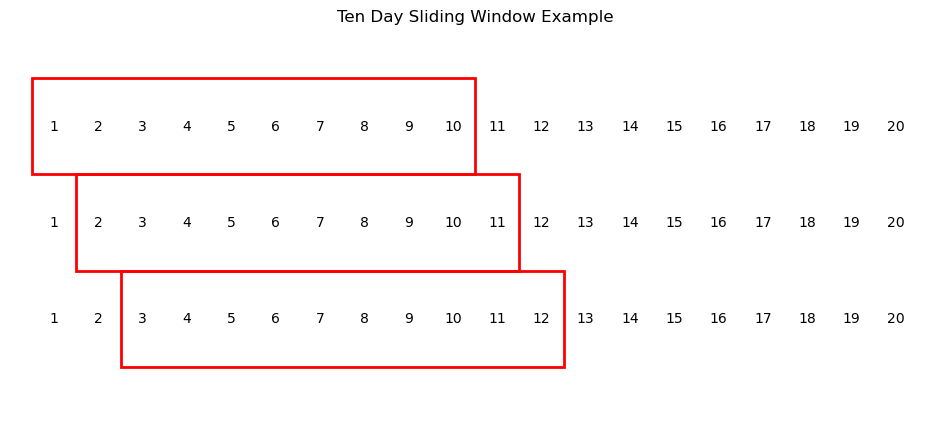

In [1]:
#| code-fold: true
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_sliding_window():
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.axis('off')
    
    y_positions = [0, -1, -2]
    window_starts = [1, 2, 3]
    
    for y, window_start in zip(y_positions, window_starts):
        for x in range(1, 21):
            ax.text(x, y, str(x), ha='center', va='center')
        
        rect = patches.Rectangle((window_start-0.5, y-0.5), 10, 1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.xlim(0, 21)
    plt.ylim(-3, 1)
    plt.title('Ten Day Sliding Window Example')

    plt.show()

draw_sliding_window()

## Training With the Sliding Window

Training accuracy improved immediately with the augmented data, with more stable training losses and validation hit rates.

The best model achieved hit rate accuracy 59% on the test data. The winning hyperparameters were:

| Parameter | Value |
| --------- | ----- |
|initial_learning_rate|0.03|
|loss_rho|0.04|
|num_ldn_layers|5|
|num_ldn_hidden_units|4|
|num_gated_relu_layers|2|
|num_gated_relu_hidden_units|8|

## Conclusion

After conducting thousands of trials, I believe I have pushed the GLDNet model to learn as much as it can from the SpotCrime data, getting within 1% of the hit rate accuracy reported in the original paper. It may not be possible for this architecture (as I have have implemented it) to learn more. Here are some future project ideas to improve accuracy:

* Spatial area selection: the street graph could be expanded to include a larger or smaller selection of streets. Instead of making rectangular cuts of the street grid, clusters of related streets could be selected by [Louvain Community Detection](https://networkx.org/documentation/stable/reference/algorithms/community.html#module-networkx.algorithms.community.louvain) or related algorithms.

* Augment spatial features: new channels of information known to be predictive of crime events could be added to each street node, such as population density or proximity to the nearest police station.

* Augment temporal features: new channels could also be added to each timestep, such as temperature or whether the timestep day is a holiday.

Two feature engineering hyperparameters could also be adjusted via optimization experiments:

* [Street intersection edge weighting](https://www.subelsky.com/crimegraph/street_graph_feature_engineering/) (`alpha`)

* [Exponential smoothing](https://www.subelsky.com/crimegraph/event_timestep_feature_engineering/#augment-the-data)


## Acknowledgements

Thank you to [SpotCrime](https://spotcrime.com/) for allowing me to use their data. Thank you to Yang Zhang and Tao Cheng for publishing [their excellent paper](https://discovery.ucl.ac.uk/id/eprint/10085742/) which was the inspiration for this project.